In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import cv2
import os

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import structures
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import DatasetCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo

setup_logger()

c:\users\javier_2\appdata\local\programs\python\python36\lib\site-packages\pycocotools\coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\javier_2\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\javier_2\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\javier_2\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\javier_2\appdata\local\programs\python\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
 

<Logger detectron2 (DEBUG)>

In [3]:
# Detectron2 docs: https://detectron2.readthedocs.io
# Tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

**Detectron2 dataset format:** https://detectron2.readthedocs.io/tutorials/datasets.html#standard-dataset-dicts
```json
- list[dict]
list of: {
    file_name - path to image
    width, height: int - the shape of the image
    image_id: str, id - identify images 
    annotations: list[dict] - {
        bbox - 4 integers representing the bounding box
        bbox_mode - mode of the box => structures.BoxMode.XYXY_ABS or XYWH_ABS / _REL
        category_id - category of object to detect 
    }
}

```

In [4]:
def draw_image_with_bbox(img, points):
    print(points)
    for box in points:
        x,y,x2,y2 = box
        #rect = patches.Rectangle((x,y),(x2,y2),linewidth=1,edgecolor='r',facecolor='none')
        cv2.rectangle(img, (x, y), (x2, y2), (0, 255, 0), 10)
    #cv2.imshow("Image", img)
    plt.imshow(img)

In [5]:
def detectron2_dataset():
    
    with open("preprocessed_data.pkl", "rb") as f:
        data = pkl.load(f)
        
    d2_data = []
    
    for idx, img in enumerate(data):
        annotations = []
        for point in img["points"]:
            
            width = img["size"][0]
            heigth = img["size"][1]
            
            x1 = int(round(point[0]*width))
            y1 = int(round(point[1]*heigth))
            
            x2 = int(round(point[2]*width))
            y2 = int(round(point[3]*heigth))
            
            annotations.append({
                "bbox": [x1, y1, x2, y2],
                "bbox_mode": structures.BoxMode.XYXY_ABS,
                "category_id": 0
            })
        
        img_d = {
            "file_name": img["img_path"],
            "width": width,
            "height": heigth, 
            "image_id": idx,
            "annotations": annotations
        }
        
        d2_data.append(img_d)
    
    return d2_data

[[139, 18, 235, 106], [145, 128, 230, 266], [292, 109, 396, 227], [429, 144, 535, 262]]


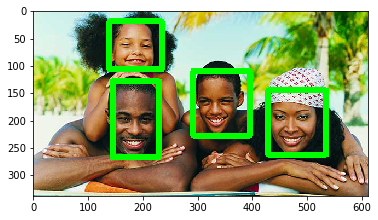

In [6]:
p_dataset = detectron2_dataset()
i = np.random.randint(len(p_dataset))
draw_image_with_bbox(cv2.imread(p_dataset[i]["file_name"]), [box["bbox"] for box in p_dataset[i]["annotations"]])

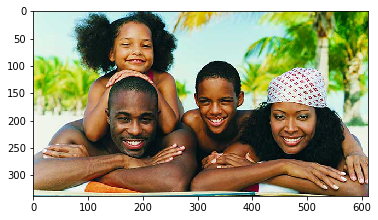

In [7]:
plt.imshow(cv2.imread(p_dataset[i]["file_name"]))

In [8]:
DatasetCatalog.register("face_detection", detectron2_dataset)
#d2_format_data = detectron2_dataset(d)

In [9]:
ITERATIONS = 1500

# "COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"

model_zoo_name = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(
  model_zoo.get_config_file(
    model_zoo_name
  )
)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  model_zoo_name
)

cfg.DATASETS.TRAIN = ("face_detection",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.CHECKPOINT_PERIOD = 200

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = ITERATIONS
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)

[05/15 09:38:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

c:\users\javier_2\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
trainer.resume_or_load(resume=False)
trainer.train()

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[05/15 09:38:34 d2.engine.train_loop]: Starting training from iteration 0
[05/15 09:39:01 d2.utils.events]:  eta: 0:15:14  iter: 19  total_loss: 1.508  loss_cls: 0.692  loss_box_reg: 0.469  loss_rpn_cls: 0.147  loss_rpn_loc: 0.017  time: 0.6089  data_time: 0.4715  lr: 0.000020  max_mem: 2256M
[05/15 09:39:11 d2.utils.events]:  eta: 0:13:52  iter: 39  total_loss: 1.497  loss_cls: 0.576  loss_box_reg: 0.725  loss_rpn_cls: 0.076  loss_rpn_loc: 0.015  time: 0.5661  data_time: 0.0010  lr: 0.000040  max_mem: 2256M
[05/15 09:39:23 d2.utils.events]:  eta: 0:13:39  iter: 59  total_loss: 1.403  loss_cls: 0.476  loss_box_reg: 0.809  loss_rpn_cls: 0.082  loss_rpn_loc: 0.024  time: 0.5669  data_time: 0.0011  lr: 0.000060  max_mem: 2256M
[05/15 09:39:35 d2.utils.events]:  eta: 0:14:01  iter: 79  total_loss: 1.461  loss_cls: 0.455  loss_box_reg: 0.888  loss_rpn_cls: 0.051  loss_rpn_loc: 0.017  time: 0.5793  data_time: 0.0012  lr: 0.000080  max_mem: 2256M
[05/15 09:39:47 d2.utils.events]:  eta: 0:13:4

FileNotFoundError: [Errno 2] No such file or directory: 'datasets\\coco/annotations/instances_val2017.json'

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

'cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")\ncfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model\ncfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.7]\ncfg.DATASETS.TEST = ("face_detection",)\npredictor = DefaultPredictor(cfg)'

In [1]:
images = os.listdir("images")
img_name = np.random.choice(images)

img_name = ""

#im = cv2.imread(os.path.join("images", img_name))
im = cv2.imread(img_name)

outputs = predictor(im)
outputs["instances"]

draw_image_with_bbox(im, outputs["instances"].pred_boxes)

FileNotFoundError: [Errno 2] No such file or directory: 'images'